In [1]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import random
import pickle
import cv2
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
import tensorflow_hub as hub
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

In [16]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [17]:
#!ls "/content/drive/My Drive/"

### Problem Statement

An AI and Computer Vision Company needs a code for classifying the images as a flip pages and non flip pages. This code can be used for mobile application. 

In [2]:
img_height, img_width, img_channels = 224,224,3
batch_size=32
train_ds = "../Data/images/training"
test_data_dir = "../Data/images/testing"
loading_dataste_seed = 0

### Load Dataset

In [3]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_ds,
    validation_split=0.2,
    subset="training",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.


In [4]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_ds,
    validation_split=0.2,
    subset="validation",
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 478 files for validation.


In [5]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=loading_dataste_seed,
    image_size=(img_height, img_width),
    batch_size=597
)

Found 597 files belonging to 2 classes.


### Function for evaluating model

In [6]:
def evaluate_model(model, test_data):
    results = {}

    predicted_labels = []
    true_labels = []
    all_images = []
    for images, labels in test_data:
        true_labels.extend(labels.numpy())
        predicted_labels.extend(tf.argmax(model.predict(images), axis=1).numpy())

    # Accuracy
    results['accuracy'] = accuracy_score(true_labels, predicted_labels)

    # F1 Score
    results['f1_score'] = f1_score(true_labels, predicted_labels)

    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)
    print("F1 score",results['f1_score'])
    print("Accuracy",results['accuracy'])



    return results

### Preparing Models

#### CNN MODEL

In [23]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 394272)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                25233472  
                                                                 
 dense_3 (Dense)             (None, 2)                

In [24]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [25]:
custom_model_history = model.fit(train_set,validation_data=validation_set,epochs=10)

Epoch 1/10
60/60 [==============================] - 52s 842ms/step - loss: 8.3142 - accuracy: 0.7680 - val_loss: 93.3565 - val_accuracy: 0.5439
Epoch 2/10
60/60 [==============================] - 48s 782ms/step - loss: 0.2994 - accuracy: 0.9002 - val_loss: 40.3004 - val_accuracy: 0.5439
Epoch 3/10
60/60 [==============================] - 48s 776ms/step - loss: 0.1357 - accuracy: 0.9608 - val_loss: 17.8369 - val_accuracy: 0.6318
Epoch 4/10
60/60 [==============================] - 48s 783ms/step - loss: 0.1760 - accuracy: 0.9681 - val_loss: 9.8891 - val_accuracy: 0.7113
Epoch 5/10
60/60 [==============================] - 49s 790ms/step - loss: 0.0797 - accuracy: 0.9932 - val_loss: 0.4246 - val_accuracy: 0.9268
Epoch 6/10
60/60 [==============================] - 48s 775ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 0.3445 - val_accuracy: 0.9833
Epoch 7/10
60/60 [==============================] - 48s 789ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 0.1784 - val_accuracy: 0.9

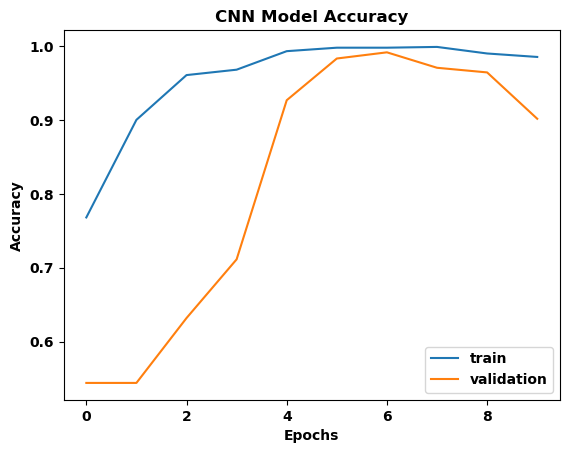

In [26]:
# Plot the CNN Model Accuracy
plt.plot(custom_model_history.history['accuracy'])
plt.plot(custom_model_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

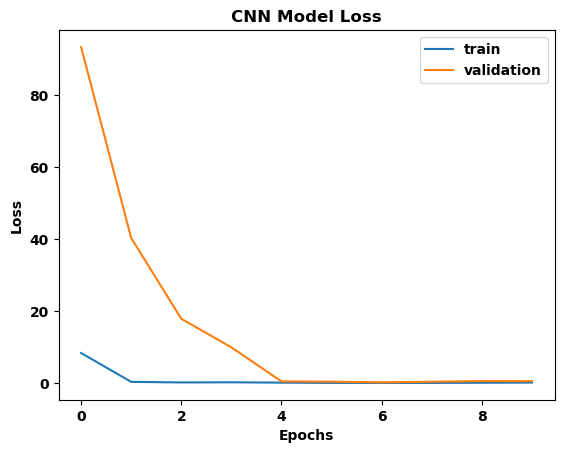

In [27]:
# Plot the CNN Model Loss
plt.plot(custom_model_history.history['loss'])
plt.plot(custom_model_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [28]:
# Evaluate the CNN Model
custom_model_evaluation = evaluate_model(model, test_set)

19/19 [==============================] - 2s 109ms/step
[[286   4]
 [ 66 241]]
F1 score 0.8731884057971014
Accuracy 0.8827470686767169


In [29]:
# Calculate the size of the CNN Model
cnn_model = '../Final_model/cnn_model.h5'
pickle.dump(model, open(cnn_model, 'wb'))
model.save(cnn_model)
cnn_model_size = format((os.path.getsize(cnn_model)/(1024*1024)),".2f")
print("CNN Model:",cnn_model_size,"MB")

INFO:tensorflow:Assets written to: ram://b04abb87-8432-4fe7-842f-92ee7d166b5e/assets


INFO:tensorflow:Assets written to: ram://b04abb87-8432-4fe7-842f-92ee7d166b5e/assets


CNN Model: 288.83 MB


#### ResNet Model

In [30]:
base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3), classes=2)
for layer in base_model.layers:
    layer.trainable=False

In [31]:
resnet_model= Sequential()
resnet_model.add(base_model)
resnet_model.add(tf.keras.layers.BatchNormalization())
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(512, activation='relu'))
resnet_model.add(tf.keras.layers.Dense(2, activation='softmax'))
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               51380736  
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 74,977,666
Trainable params: 51,385,858
Non-trainable params: 23,591,808
_________________________________

In [32]:
resnet_model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [33]:
resnet_model_history = resnet_model.fit(train_set,validation_data=validation_set,epochs=10)

Epoch 1/10
60/60 [==============================] - 270s 4s/step - loss: 5.2601 - accuracy: 0.8992 - val_loss: 2.2674 - val_accuracy: 0.9540
Epoch 2/10
60/60 [==============================] - 259s 4s/step - loss: 0.4439 - accuracy: 0.9833 - val_loss: 0.4334 - val_accuracy: 0.9895
Epoch 3/10
60/60 [==============================] - 256s 4s/step - loss: 0.0648 - accuracy: 0.9958 - val_loss: 0.9832 - val_accuracy: 0.9791
Epoch 4/10
60/60 [==============================] - 258s 4s/step - loss: 0.4651 - accuracy: 0.9848 - val_loss: 1.0320 - val_accuracy: 0.9707
Epoch 5/10
60/60 [==============================] - 262s 4s/step - loss: 0.2671 - accuracy: 0.9869 - val_loss: 0.5030 - val_accuracy: 0.9916
Epoch 6/10
60/60 [==============================] - 265s 4s/step - loss: 0.0773 - accuracy: 0.9948 - val_loss: 1.2588 - val_accuracy: 0.9749
Epoch 7/10
60/60 [==============================] - 258s 4s/step - loss: 0.0662 - accuracy: 0.9963 - val_loss: 0.3957 - val_accuracy: 0.9937
Epoch 8/10
60

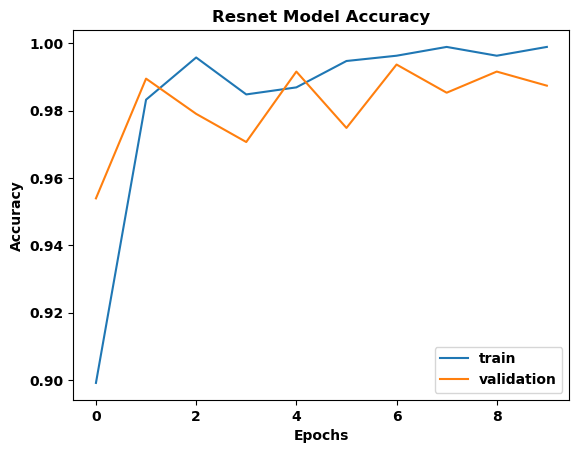

In [34]:
# Plot the ResNet Model Accuracy
fig1 = plt.gcf()
plt.plot(resnet_model_history.history['accuracy'])
plt.plot(resnet_model_history.history['val_accuracy'])
plt.title('Resnet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

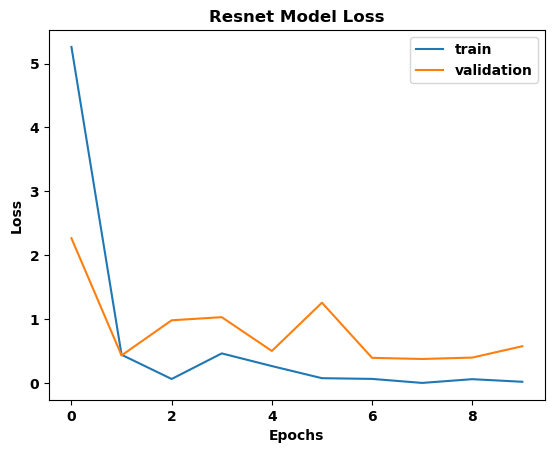

In [35]:
# Plot the ResNet Model Loss
plt.plot(resnet_model_history.history['loss'])
plt.plot(resnet_model_history.history['val_loss'])
plt.title('Resnet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [36]:
# Evaluate the ResNet Model
resnet_model_evaluation = evaluate_model(resnet_model, test_set)

19/19 [==============================] - 56s 3s/step
[[283   7]
 [  0 307]]
F1 score 0.9887278582930756
Accuracy 0.9882747068676717


In [37]:
# Calculate the size of the ResNet Model
res_model_path = '../Final_model/res_model.h5'
pickle.dump(resnet_model, open(res_model_path, 'wb'))
resnet_model.save(res_model_path)
res_model_size = format((os.path.getsize(res_model_path)/(1024*1024)),".2f")
print("Resnet Model:",res_model_size,"MB")

INFO:tensorflow:Assets written to: ram://e30669d6-94fb-4059-a198-4a1c78e7208d/assets


INFO:tensorflow:Assets written to: ram://e30669d6-94fb-4059-a198-4a1c78e7208d/assets


Resnet Model: 678.39 MB


#### Mobile Net Model

In [7]:
mobilenet_model = Sequential()

mobilenet_pretrained_model= tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=(img_width, img_height, img_channels),
    pooling='avg',
    weights='imagenet'
)

for layer in mobilenet_pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(mobilenet_pretrained_model)
mobilenet_model.add(tf.keras.layers.Flatten())
mobilenet_model.add(tf.keras.layers.Dense(512, activation='relu'))
mobilenet_model.add(tf.keras.layers.Dense(2, activation='softmax'))
mobilenet_model.summary()
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
mobilenet_history = mobilenet_model.fit(train_set,validation_data=validation_set,epochs=10)

Epoch 1/10
60/60 [==============================] - 182s 2s/step - loss: 0.6581 - accuracy: 0.7074 - val_loss: 0.4173 - val_accuracy: 0.8368
Epoch 2/10
60/60 [==============================] - 74s 1s/step - loss: 0.3029 - accuracy: 0.8856 - val_loss: 0.3332 - val_accuracy: 0.8556
Epoch 3/10
60/60 [==============================] - 69s 1s/step - loss: 0.2364 - accuracy: 0.9117 - val_loss: 0.2601 - val_accuracy: 0.8975
Epoch 4/10
60/60 [==============================] - 69s 1s/step - loss: 0.1767 - accuracy: 0.9431 - val_loss: 0.1836 - val_accuracy: 0.9331
Epoch 5/10
60/60 [==============================] - 70s 1s/step - loss: 0.1252 - accuracy: 0.9603 - val_loss: 0.2237 - val_accuracy: 0.9079
Epoch 6/10
60/60 [==============================] - 68s 1s/step - loss: 0.1279 - accuracy: 0.9577 - val_loss: 0.1489 - val_accuracy: 0.9435
Epoch 7/10
60/60 [==============================] - 69s 1s/step - loss: 0.1078 - accuracy: 0.9619 - val_loss: 0.1087 - val_accuracy: 0.9582
Epoch 8/10
60/60 [=

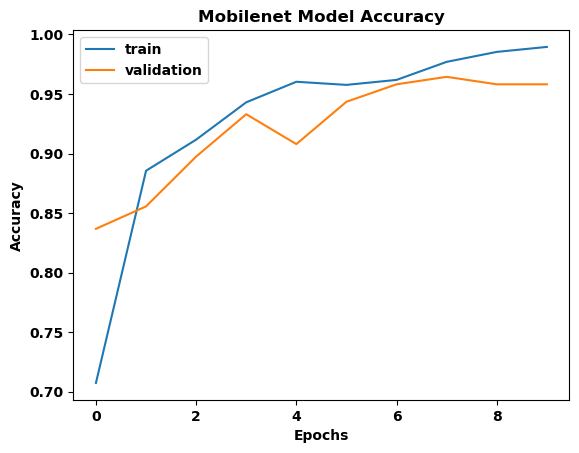

In [9]:
# Plot the MobileNet Model Accuracy
fig1 = plt.gcf()
plt.plot(mobilenet_history.history['accuracy'])
plt.plot(mobilenet_history.history['val_accuracy'])
plt.title('Mobilenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

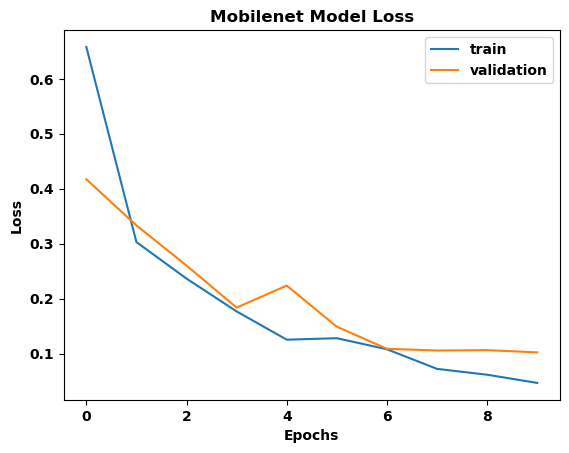

In [10]:
# Plot the MobileNet Model Loss
plt.plot(mobilenet_history.history['loss'])
plt.plot(mobilenet_history.history['val_loss'])
plt.title('Mobilenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [11]:
# Evaluate the MobileNet Model
mobilenet_model_evaluation = evaluate_model(mobilenet_model, test_set)

19/19 [==============================] - 17s 781ms/step
[[267  23]
 [  0 307]]
F1 score 0.9638932496075354
Accuracy 0.9614740368509213


In [12]:
# Calculate the size of the MobileNet Model
mobile_model_path = '../Final_model/mobile_model.h5'
pickle.dump(mobilenet_model, open(mobile_model_path, 'wb'))
mobilenet_model.save(mobile_model_path)
mobile_model_size = format((os.path.getsize(mobile_model_path)/(1024*1024)),".2f")
print("Mobile Net Model:",mobile_model_size,"MB")

INFO:tensorflow:Assets written to: ram://22d73394-338b-4894-b251-3c835d87356c/assets


INFO:tensorflow:Assets written to: ram://22d73394-338b-4894-b251-3c835d87356c/assets


Mobile Net Model: 16.43 MB


### Conclusion:

As per the requirement of the company, we build deep learning model which can detect the image of the book shows flip page or not. Though out of the CNN,Resnet and Mobile net models, Resnet is giving hightest accuracy. But company need to use this model in mobile app, so we choose mobile net model with f1 score 97.9%. 